In [1]:
import sys
import time
from collections import deque
import collections
import itertools

import daft
import arviz as az
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import networkx as nx
import seaborn as sns
import torch
tt = torch.tensor
import pyro
from pyro.distributions import Normal, Uniform, Exponential, LogNormal
from pyro.infer import SVI, Predictive, Trace_ELBO #, NUTS, MCMC
from pyro.optim import Adam, SGD
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean, AutoNormal, AutoLaplaceApproximation

#from pyro.infer.mcmc.api import MCMC, NUTS
from utils import draw_PGM, HPDI, precis, conditional_independencies, conditional_independencies_v2, find_adjustment_sets, marginal_independencies
#seed = 43
#np.random.seed(seed)
#pyro.set_rng_seed(seed)
torch.multiprocessing.set_sharing_strategy('file_system')

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jul 14 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

tqdm      : 4.66.4
pyro      : 1.9.1
daft      : 0.1.2
numpy     : 1.26.4
matplotlib: 3.9.0
pandas    : 2.2.2
scipy     : 1.12.0
seaborn   : 0.12.2
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
networkx  : 3.1
torch     : 2.3.0
arviz     : 0.17.1

Watermark: 2.4.3



### Code 6.1
Unfortunately due to selection bias, previously uncorrelated predictors can become falsely correlated. For example, if newsworthiness and trustworthiness of an article are weighted equally, and only the top 10% of submitted articles are accepted, there will become a negative correlation between newsworthiness and trustworthiness amongst published articles. If you don't condition on whether an article is published or not, the correlation disappears!

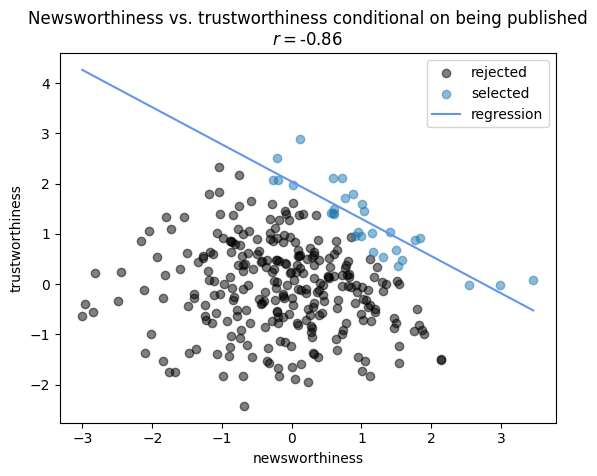

In [3]:
N = 300 # number of submitted articles
p = 0.1 # top fraction to accept
# generate uncorrelated newsworthiness (nw) /trustworthiness (tw)
nw = np.random.randn(N)
tw = np.random.randn(N)
# select top 10% of combined scores
score = nw + tw
q = np.quantile(score, 1-p)
mask = (score >= q)

# Visualize correlation
plt.scatter(nw[~mask], tw[~mask], color="black", alpha=0.5, label="rejected")
plt.scatter(nw[mask], tw[mask], color="C0", alpha=0.5, label="selected")
m, b, r, _, _ = st.linregress(nw[mask], tw[mask])
x = np.linspace(nw.min(), nw.max())
y = m*x + b
plt.plot(x, y, color="cornflowerblue", label="regression")
plt.title("Newsworthiness vs. trustworthiness conditional on being published\n$r=$"f"{r:.2f}")
plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")
plt.legend()
plt.show()

### Code 6.2 - 6.6
We will explore multicollinearity by simulating an experiment where a population of various heights and leg length proportions is generated, and then a small, asymmetry between the left/right legs is also generated.

In [4]:
N = 100
height = Normal(10, 2.0).sample([N])
leg_prop = Uniform(0.4, 0.5).sample([N])
leg_left = leg_prop * height + Normal(0, 0.2).sample([N])
leg_right = leg_prop * height + Normal(0, 0.2).sample([N])

df = pd.DataFrame({ "height": height.numpy(), \
                    "leg_left": leg_left.numpy(), \
                    "leg_right": leg_right.numpy()
                })
df.head() 

,height,leg_left,leg_right
0,14.520695,6.277314,6.865138
1,8.836485,4.184604,4.121055
2,10.137979,3.994817,4.074943
3,8.607974,4.127484,4.310256
4,11.950069,4.709492,4.502223


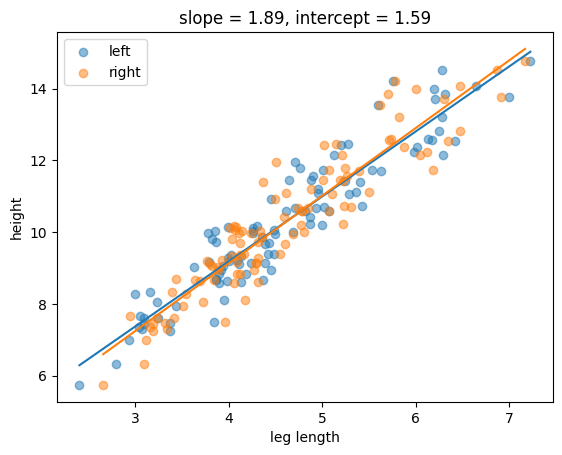

In [5]:
for side in ["left", "right"]:
    x = df[f"leg_{side}"]
    y = df["height"]
    plt.scatter(x, y, alpha=0.5, label=side)
    m, b, _, _, _ = st.linregress(x, y)
    x = np.linspace(x.min(), x.max())
    y = m * x + b
    plt.plot(x, y)
plt.title(f"slope = {m:.2f}, intercept = {b:.2f}")
plt.legend()
plt.xlabel("leg length")
plt.ylabel("height")
#plt.xlim((1,9))
#plt.ylim((1,16))
plt.show()

In [6]:
class LegSim:
    def __init__(self, df):
        self.height = tt(df["height"].values).double()
        self.left = tt(df["leg_left"].values).double()
        self.right = tt(df["leg_right"].values).double()
        
    def __call__(self):
        a = pyro.sample("a", Normal(*tt((10., 100.))))
        bl = pyro.sample("bl", Normal(*tt((2., 10.))))
        br = pyro.sample("br", Normal(*tt((2., 10.))))
        sigma = pyro.sample("sigma", Exponential(tt(1.)))
        mu = pyro.deterministic("mu", a + bl*self.left + br*self.right)
        with pyro.plate("N", len(self.height)):
            pyro.sample("height", Normal(mu, sigma), obs=self.height)
        
    def train(self, guide, num_steps):
        pyro.clear_param_store()
        # Initializing to the mean actually causes the multicollinearity to go away...
        #self.guide = AutoMultivariateNormal(self, init_loc_fn=init_to_mean)
        self.guide = guide(self)
        #self.guide = AutoLaplaceApproximation(self)
        svi = SVI(self, guide=self.guide, optim=Adam({"lr": 0.01}), loss=Trace_ELBO())
        loss = []
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

  0%|          | 0/40000 [00:00<?, ?it/s]

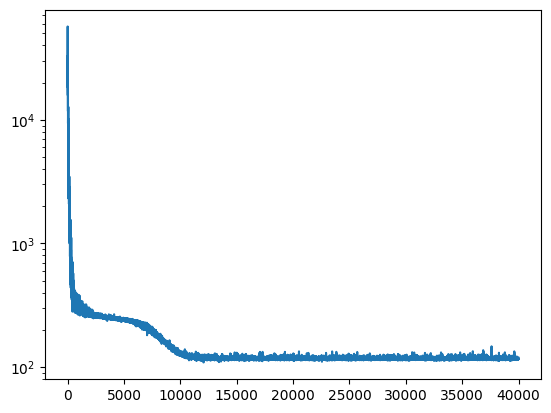

In [7]:
x = tt(df["leg_left"].values).double()
y = tt(df["height"].values).double()
m6_1 = LegSim(df)
loss = m6_1.train(AutoMultivariateNormal, 40000) # takes VERY long time to train
plt.plot(loss); plt.yscale("log"); plt.show()


Let's sample from the posterior... we can see that the distributions for $bl$ and $br$ are pretty messed up; very wide HPDI. If we were to run the training again, it is very likely we would get different mean values as well.

In [8]:
def sample_posterior(model, num_samples, sites=None):
    return {
        k: v.detach().numpy()
        for k, v in Predictive(
            model,
            guide=model.guide,
            num_samples=num_samples,
            return_sites=sites,
        )().items()
    }

def sample_prior(model, num_samples, sites=None):
    return {
        k: v.detach().numpy()
        for k, v in Predictive(
            model,
            {},
            return_sites=sites,
            num_samples=num_samples
        )().items()
    }

In [9]:
samples = sample_posterior(m6_1, 1000, sites=("a", "bl", "br", "sigma"))
precis(samples)

,mean,stddev,5.5%,94.5%
a,1.6284,0.308398,1.132193,2.116952
bl,1.100034,0.173738,0.833942,1.391738
br,0.770732,0.171992,0.478707,1.041304
sigma,0.64762,0.046546,0.573722,0.720411


In [10]:
def plot_intervals(samples, p):
    for i, (k, s) in enumerate(samples.items()):
        mean = s.mean()
        hpdi = HPDI(s, p)
        plt.scatter([mean], [i], facecolor="none", edgecolor="black")
        plt.plot(hpdi, [i, i], color="C0")
        plt.axhline(i, color="grey", alpha=0.5, linestyle="--")
    plt.yticks(range(len(samples)), samples.keys(), fontsize=15)
    plt.axvline(0, color="black", alpha=0.5, linestyle="--")

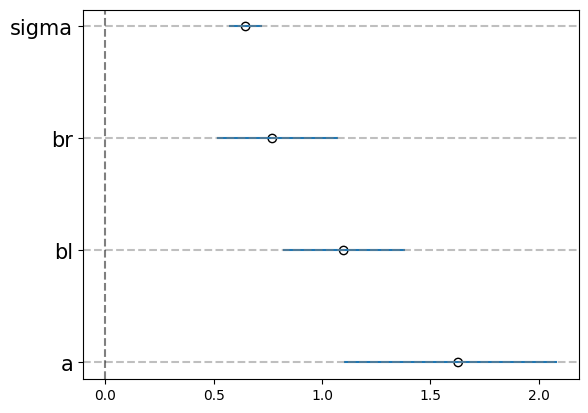

In [11]:
plot_intervals(samples, 0.89)

But the prediction turns out fine! The residuals from the mean are fairly small given how big the coefficients are. What gives? Why are the posteriors so broad, but give the right answer?

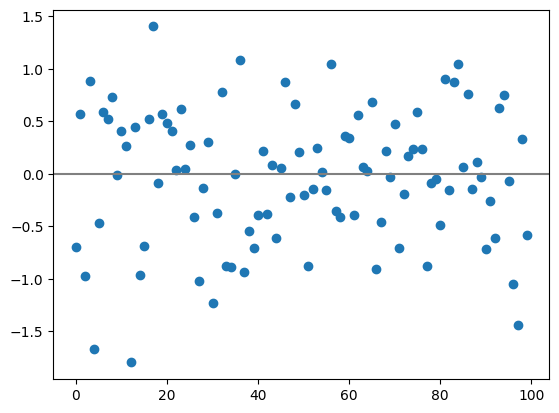

In [12]:
a = samples["a"].mean()
bl = samples["bl"].mean()
br = samples["br"].mean()
y = a + bl * df["leg_left"].values + br * df["leg_right"].values
plt.scatter(range(len(y)), y - df["height"])
plt.axhline(0, color="gray")
plt.show()

Well, it's _multicollinearity_; because the predictors leg_left and leg_right are so similar, we have $l_i \approx r_i$, and therefore
$$
h_i = a + bl * l_i + br * r_i \approx a + bl * l_i + br * l_i = a + (bl + br) * l_i
$$

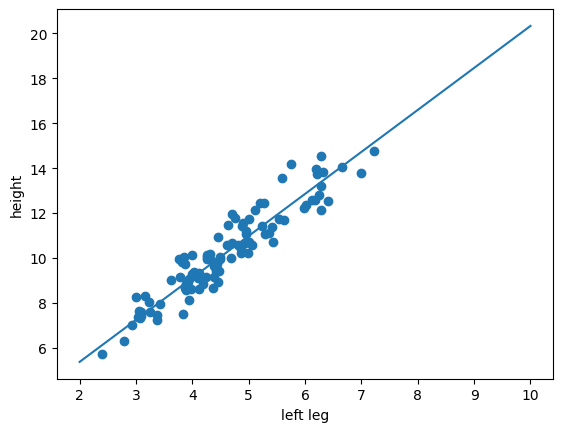

In [13]:
plt.scatter(df["leg_left"], df["height"])
a = samples["a"].mean()
bl = samples["bl"].mean()
br = samples["br"].mean()
x = np.linspace(2, 10)

y = a + (bl + br) * x

plt.plot(x, y)
plt.xlabel("left leg")
plt.ylabel("height")
plt.show()

We can see that $bl$ and $br$ are _highly_ negatively correlated with each other, which makes sense; because the sum $bl+br$ is the only thing that matters, you can increase $bl$ at the cost of decreasing $br$ - their sum remains the same.

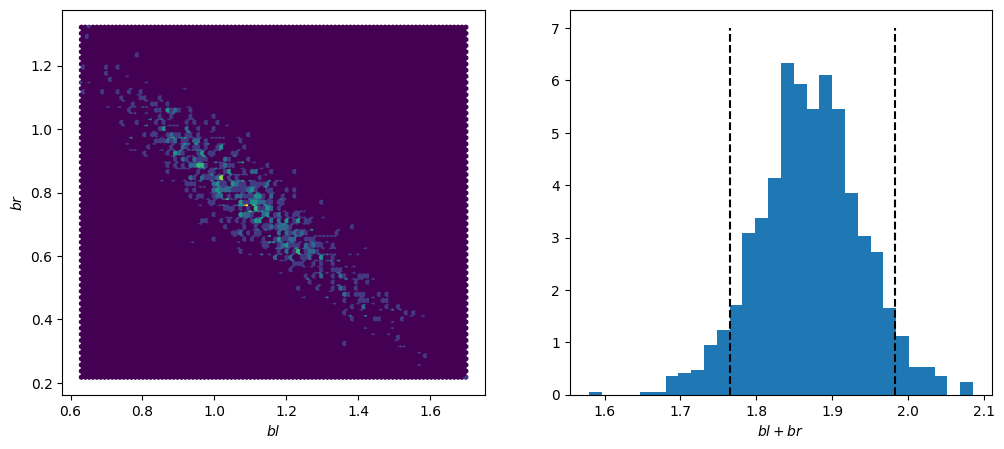

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
plt.sca(axes[0])
plt.hexbin(samples["bl"], samples["br"])
plt.xlabel("$bl$")
plt.ylabel("$br$")
plt.sca(axes[1])
plt.hist(samples["bl"] + samples["br"], bins=30, density=True)
plt.xlabel("$bl + br$")
hpdi = HPDI(samples["bl"] + samples["br"], 0.89)
plt.vlines(hpdi[0].item(), 0, 7, color="black", linestyles="--")
plt.vlines(hpdi[1].item(), 0, 7, color="black", linestyles="--")
plt.show()

### Code 6.8
Look at the milk data again

In [15]:
milk_df = pd.read_csv("data/milk.csv", sep=";")
milk_df.sample(4)

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
17,Old World Monkey,M mulatta,0.97,55.51,13.17,31.32,3.24,70.41
10,New World Monkey,Cebuella pygmaea,0.80,41.35,20.85,37.80,0.12,58.85
21,Ape,Hylobates lar,0.62,34.51,12.57,52.92,5.37,67.53
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN


In [16]:
rename = {"kcal.per.g": "K", "perc.fat": "F", "perc.lactose": "L"}
df = milk_df[rename.keys()].rename(columns=rename)
for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()

### Code 6.9
Do simple linear regression of $K$ on $F$ and $L$ separately

In [17]:
class RegressionBase:
    def __init__(self, df, categoricals=None):
        if categoricals is None:
            categoricals = []
        for col in set(df.columns) - set(categoricals):
            setattr(self, col, tt(df[col].values).double())
        for col in categoricals:
            setattr(self, col, tt(df[col].values).long())
            
    def __call__(self):
        raise NotImplementedError
        
    def train(self, num_steps, lr=0.01):
        pyro.clear_param_store()
        self.guide = AutoMultivariateNormal(self, init_loc_fn=init_to_mean)
        svi = SVI(self, guide=self.guide, optim=Adam({"lr": lr}), loss=Trace_ELBO())
        loss = []
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

class M6_3(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 0.2))
        bF = pyro.sample("bF", Normal(0, 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = pyro.deterministic("mu", a + bF*self.F)
        with pyro.plate("N", len(self.K)):
            pyro.sample("height", Normal(mu, sigma), obs=self.K)
        
class M6_4(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 0.2))
        bL = pyro.sample("bL", Normal(0, 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = pyro.deterministic("mu", a + bL*self.L)
        with pyro.plate("N", len(self.K)):
            pyro.sample("height", Normal(mu, sigma), obs=self.K)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

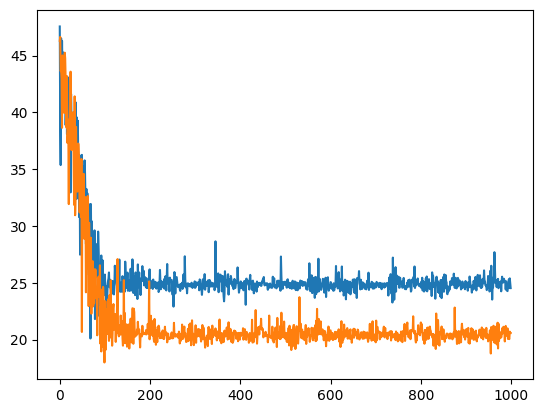

In [18]:
m6_3 = M6_3(df)
m6_4 = M6_4(df)
loss = m6_3.train(1000)
plt.plot(loss)
loss = m6_4.train(1000)
plt.plot(loss)
plt.show()

In [19]:
samples3 = sample_posterior(m6_3, 1000, ("a", "bF", "sigma"))
samples4 = sample_posterior(m6_4, 1000, ("a", "bL", "sigma"))

           mean    stddev      5.5%     94.5%
a      0.013299   0.06627 -0.090202  0.115165
bF     0.861357  0.070415  0.751605  0.971913
sigma  0.496097  0.069345  0.391263  0.615472


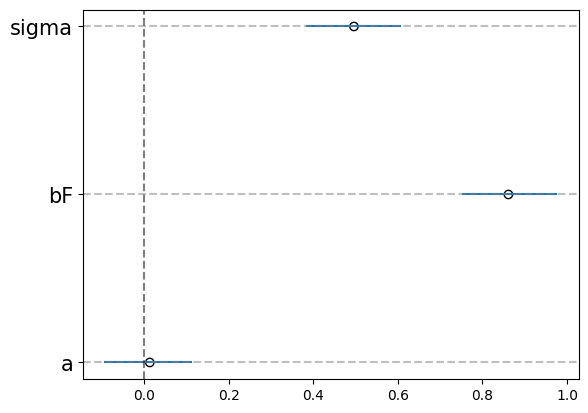

In [20]:
print(precis(samples3))
plot_intervals(samples3, 0.89)

           mean    stddev      5.5%     94.5%
a     -0.008811   0.06368 -0.106969  0.094351
bL    -0.886652  0.068852 -0.993967 -0.776248
sigma  0.403796  0.053267  0.324929  0.491994


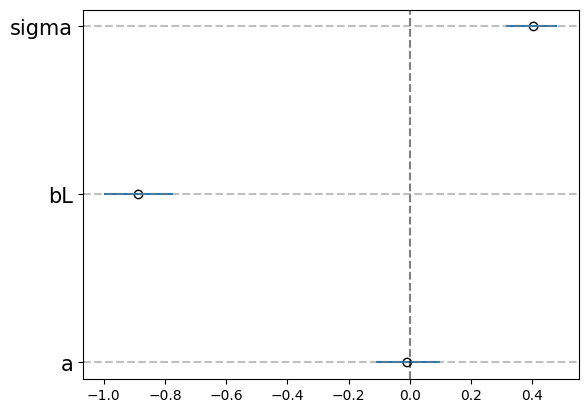

In [21]:
print(precis(samples4))
plot_intervals(samples4, 0.89)

### Code 6.10
Now put both $F$ and $L$ as predictiors in the same model

  0%|          | 0/10000 [00:00<?, ?it/s]

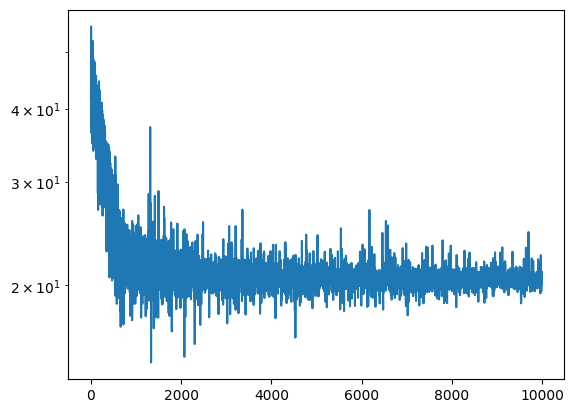

In [22]:
class M6_5(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 0.2))
        bF = pyro.sample("bF", Normal(0., 0.5))
        bL = pyro.sample("bL", Normal(0., 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = pyro.deterministic("mu", a + bF*self.F + bL*self.L)
        with pyro.plate("N", len(self.K)):
            pyro.sample("K", Normal(mu, sigma), obs=self.K)
        
m6_5 = M6_5(df)
loss = m6_5.train(10000, 0.001)
plt.plot(loss); plt.yscale("log"); plt.show()

           mean    stddev      5.5%     94.5%
a      -0.00217  0.068713 -0.121165   0.10748
bF     0.238652  0.164297 -0.032265  0.507359
bL    -0.670207  0.173257 -0.948044 -0.396232
sigma   0.41592  0.058293  0.329895  0.519799


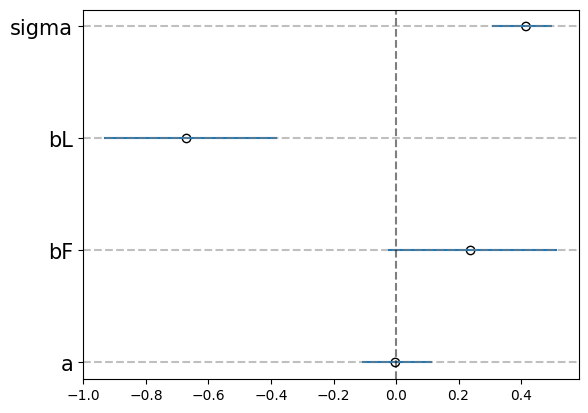

In [23]:
samples = sample_posterior(m6_5, 1000, ("a", "bL", "bF", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)

### Code 6.11
Make a pairs plot of the variables in this model. You can see that $F$ and $L$ are very negatively correlated. The author's hypothesis is that there is some latent, unobserved variable which causally influences both $F$ and $L$. It would be better if we could simply regress $K$ on this latent, but we do not know it!

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

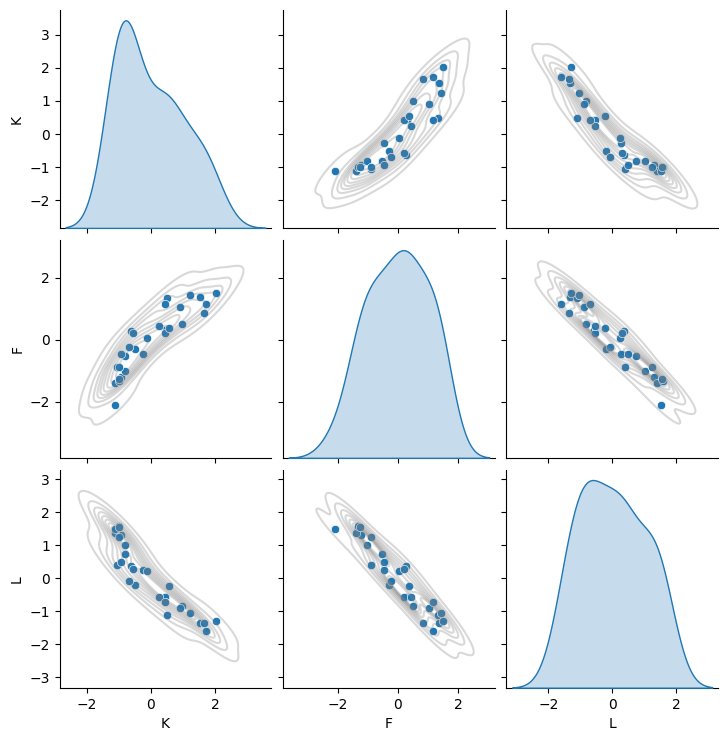

In [24]:
g = sns.pairplot(df, kind="scatter", diag_kind="kde")
g.map_lower(sns.kdeplot, color=".5", alpha=0.3)
g.map_upper(sns.kdeplot, color=".5", alpha=0.3)


An example of a causal diagram in which $F$ and $L$ are influenced by some (unobserved) variable $D$.

$$X \perp Y \| Z$$

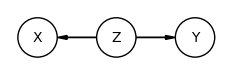

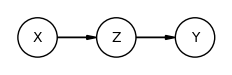

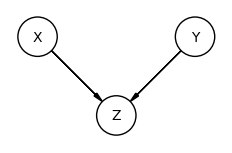

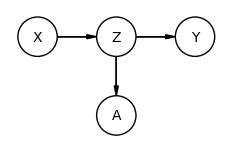

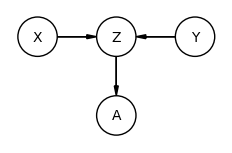

In [25]:
G = nx.DiGraph((("Z", "X"), ("Z", "Y")))
coordinates = {"X": (0, 0), "Z": (1, 0), "Y": (2, 0)}
draw_PGM(G, coordinates)

G = nx.DiGraph((("X", "Z"), ("Z", "Y")))
coordinates = {"X": (0, 0), "Z": (1, 0), "Y": (2, 0)}
draw_PGM(G, coordinates)

G = nx.DiGraph((("X", "Z"), ("Y", "Z")))
coordinates = {"X": (0, 0), "Z": (1, -1), "Y": (2, 0)}
draw_PGM(G, coordinates)

G = nx.DiGraph((("X", "Z"), ("Z", "Y"), ("Z", "A")))
coordinates = {"X": (0, 0), "Z": (1, 0), "Y": (2, 0), "A": (1, -1), }
draw_PGM(G, coordinates)


G = nx.DiGraph((("X", "Z"), ("Y", "Z"), ("Z", "A")))
coordinates = {"X": (0, 0), "Z": (1, 0), "Y": (2, 0), "A": (1, -1), }
draw_PGM(G, coordinates)


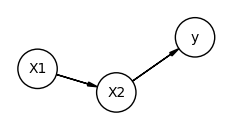

In [26]:
G = nx.DiGraph((("X1", "X2"), ("X2", "y")))
coordinates = {"X1": (0, 0), "X2": (1, -0.3), "y": (2, 0.4)}
draw_PGM(G, coordinates)

In [27]:
G = nx.DiGraph((("D", "F"), ("D", "L"), ("L", "K"), ("F", "K")))
#nx.draw_networkx(G)

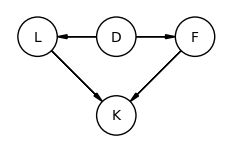

In [28]:
# TODO draw the above diagram using daft nicely. 
coordinates = {"L": (0, 0), "F": (2, 0), "D": (1, 0), "K": (1, -1)}
draw_PGM(G, coordinates)

### Code 6.12
Simulate the growth of some plants subjected to an anti-fungal treatment, then analyze the effect of including the presence of fungus (a "post-treatment" effect)

In [29]:
N = 100
h0 = 2*np.random.randn(N) + 10 # heights
treatment = np.random.choice((0, 1), N)
fungus = st.binom(n=1, p=(0.5-0.4*treatment)).rvs(N)
h1 = h0 + (5 - 3*fungus) + np.random.randn(N)
d = pd.DataFrame([h0, h1, treatment, fungus], index=["h0", "h1", "treatment", "fungus"]).T
print(precis({k: d[k].values for k in d.columns}))
d.sample(3)

                mean    stddev      5.5%      94.5%
h0          9.966357  2.275229  6.606071  13.518586
h1         14.084891  2.830198   9.35308  18.483009
treatment       0.51    0.4999       0.0        1.0
fungus          0.29  0.453762       0.0        1.0


,h0,h1,treatment,fungus
9,8.287072,12.561989,1.0,0.0
72,10.581235,15.605829,1.0,0.0
91,9.757468,16.068624,1.0,0.0


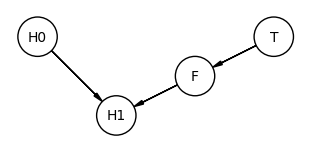

In [30]:
G = nx.DiGraph((("H0", "H1"), ("F", "H1"), ("T", "F")))
coordinates = {"H0": (-1, 1), "H1": (0,0), "F": (1, 0.5),  "T": (2, 1)}
draw_PGM(G, coordinates)

### Code 6.14 - 6.15
Let's do a simple regression using just the initial height as a predictor, and trying to infer the ratio between final/initial heights: $p = h_1/h_0$, which will be given a lognormal prior.

In [31]:
class M6_6(RegressionBase):
    def __call__(self):
        p = pyro.sample("p", LogNormal(0., 0.25))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = pyro.deterministic("mu", self.h0 * p)
        with pyro.plate("N"):
            pyro.sample("h1", Normal(mu, sigma), obs=self.h1)

  0%|          | 0/1000 [00:00<?, ?it/s]

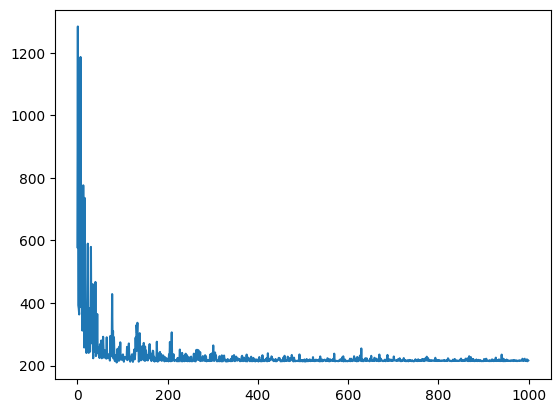

In [32]:
m6_6 = M6_6(d[["h1", "h0"]])
loss = m6_6.train(1000)
plt.plot(loss); plt.show()

In [33]:
samples = sample_prior(m6_6, 1000, ("p", "sigma"))
precis(samples)

,mean,stddev,5.5%,94.5%
p,1.020575,0.247735,0.667219,1.449821
sigma,1.01484,1.058195,0.059888,2.956339


In [34]:
samples = sample_posterior(m6_6, 1000, ("p", "sigma"))
precis(samples)

,mean,stddev,5.5%,94.5%
p,1.384511,0.038573,1.323765,1.442539
sigma,2.018083,0.149334,1.792482,2.26192


### Code 6.16
Do regression but using `treatment` and `fugus` as categorical predictors

  0%|          | 0/1000 [00:00<?, ?it/s]

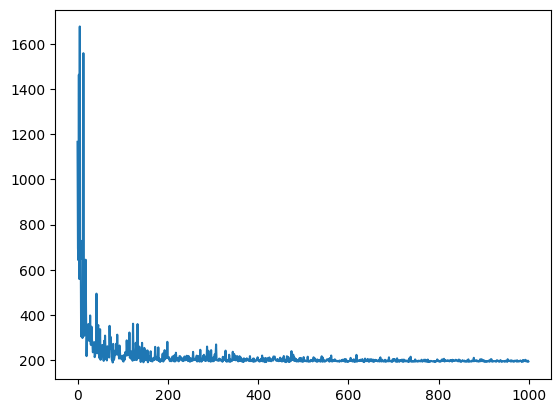

In [35]:
class M6_7(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", LogNormal(0., 0.25))
        bt = pyro.sample("bt", Normal(0., 0.5))
        bf = pyro.sample("bf", Normal(0, 0.5))
        p = pyro.deterministic("p", a + bt * self.treatment + bf * self.fungus)
        mu = pyro.deterministic("mu", self.h0 * p)
        sigma = pyro.sample("sigma", Exponential(1.))
        with pyro.plate("N"):
            pyro.sample("h1", Normal(mu, sigma), obs=self.h1)

m6_7 = M6_7(d, categoricals=["treatment", "fungus"])
loss = m6_7.train(1000)
plt.plot(loss); plt.show()

In [36]:
samples = sample_posterior(m6_7, 1000, ("a", "bt", "bf", "sigma"))
precis(samples)

,mean,stddev,5.5%,94.5%
a,1.444929,0.046618,1.371691,1.518929
bt,0.037071,0.045664,-0.035604,0.111894
bf,-0.259143,0.054047,-0.348517,-0.174239
sigma,1.59268,0.125984,1.391825,1.802666


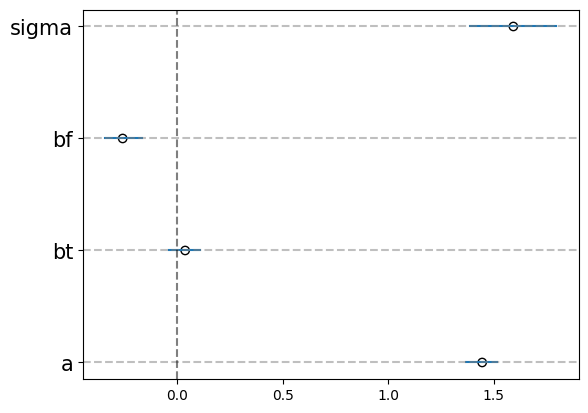

In [37]:
plot_intervals(samples, 0.89)

### Code 6.17-6.19

Interesting how the `treatment` appears to have very little effect; the value of `bt` is very close to zero and the distribution is pretty tight. Schematically, our data generating model implies the following causal diagram:

In [38]:
#!pip install daft

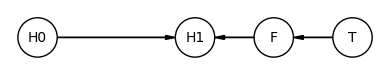

In [39]:
G = nx.DiGraph((("treatment", "fungus"), ("h0", "h1"), ("fungus", "h1")))
#nx.draw_networkx(G)

plant_dag = nx.DiGraph()
plant_dag.add_edges_from([("H0", "H1"), ("F", "H1"), ("T", "F")])
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
draw_PGM(plant_dag, coordinates)


Note how `treatment` is "blocked" by `fungus`... if we know `fungus`, there's basically no point in knowing `treatment`. In fact, let's take a look at the conditional/marginal independencies of this DAG:

In [40]:
conditional_independencies(G)


[('treatment', 'h0', 'fungus'),
 ('treatment', 'h0', 'h1'),
 ('treatment', 'h1', 'fungus'),
 ('fungus', 'h0', 'treatment')]

In [41]:
conditional_independencies_v2(G)

defaultdict(list,
            {('fungus', 'h0'): [set()],
             ('h0', 'treatment'): [set()],
             ('h1', 'treatment'): [{'fungus'}]})

In [42]:
marginal_independencies(G)

[('treatment', 'h0', {}), ('fungus', 'h0', {})]

Some of these are pretty obvious, like both `treatment` and `fungus` are marginally independent of `h0`... there is no way the initial height of the plant influences the treatment/fungus or vice versa (unless there was some preferential application of treatment to taller/shorter plants, which there isn't). However, we can see that there is one that says that `treatment`/`h1` are independent given `fungus`. Basically saying that there is no way `treatment` is not useful as a predictor anymore given access to `fungus`. So what would the regression look like if we simply removed `fungus` as a predictor?

  0%|          | 0/1000 [00:00<?, ?it/s]

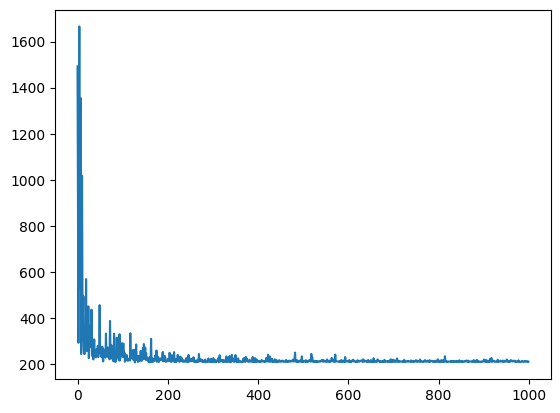

In [43]:
class M6_8(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", LogNormal(0., 0.25))
        bt = pyro.sample("bt", Normal(0., 0.5))
        p = pyro.deterministic("p", a + bt * self.treatment)
        mu = pyro.deterministic("mu", self.h0 * p)
        sigma = pyro.sample("sigma", Exponential(1.))
        with pyro.plate("N"):
            pyro.sample("h1", Normal(mu, sigma), obs=self.h1)
        
m6_8 = M6_8(d, categoricals=["treatment", "fungus"])
loss = m6_8.train(1000)
plt.plot(loss); plt.show()

           mean    stddev      5.5%     94.5%
a       1.33485  0.041361  1.270118   1.40273
bt     0.129312  0.056462  0.038548  0.218089
sigma  1.907979  0.148305   1.68153  2.146996


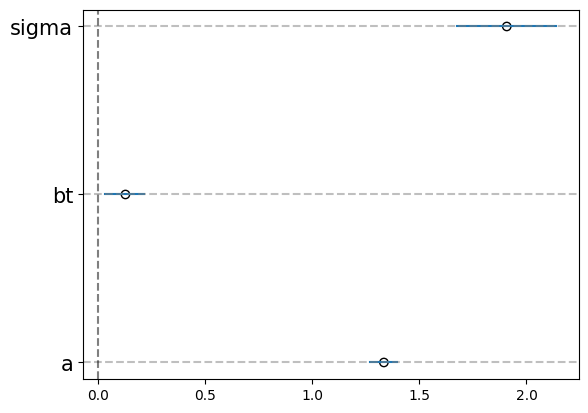

In [44]:
samples = sample_posterior(m6_8, 1000, ("a", "bt", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)

Now we can see that `treatment` has a (small) nonzero effect on `h1` equivalent to increasing plant growth by about 10%.

### Code 6.20
We can see that the treatment DOES have an affect on the plant growth, but what if it turned out that the treatment/fugus were spurious predictors, and didn't acutally causally influence growth? This could be achieved if there was some unobserved confounding factor that influenced both `h1` and `fugus`, and `fungus` didn't actually influence it at all. Let's pretend that this unobserved node is "moisture", and draw the DAG for it:

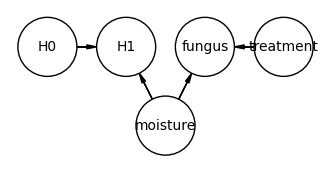

In [45]:
G = nx.DiGraph((("H0", "H1"), ("moisture", "H1"), ("treatment", "fungus"), ("moisture", "fungus")))
#nx.draw_networkx(G)

coordinates = {"H0": (0, 0), "treatment": (3, 0), "fungus": (2, 0), "H1": (1, 0), "moisture": (1.5,-1.0)}
draw_PGM(G, coordinates, node_unit=1.5)

Now let's re-generate the data using moisture $M$ as a confounding factor and run the analysis on the two models m6_7 and m6_8

In [46]:
N = 1000
h0 = 10 + 2*np.random.randn(N)
treatment = np.random.choice((0, 1), size=N)
M = st.bernoulli(p=0.5).rvs(N)
fungus = st.binom(n=1, p=(0.5-0.4*treatment + 0.4*M)).rvs(N)
h1 = h0 + (5 + 3*M) + np.random.randn(N)
d2 = pd.DataFrame([h0, h1, treatment, fungus], index=["h0", "h1", "treatment", "fungus"]).T
precis({k: d2[k].values for k in d2.columns})

,mean,stddev,5.5%,94.5%
h0,10.020953,1.965432,6.835369,13.235554
h1,16.567657,2.670744,12.200564,20.917029
treatment,0.496,0.499984,0.0,1.0
fungus,0.506,0.499964,0.0,1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

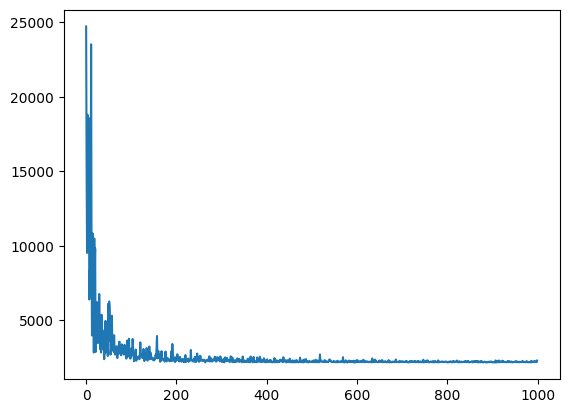

In [47]:
m6_7 = M6_7(d2, categoricals=["treatment", "fungus"])
loss = m6_7.train(1000)
plt.plot(loss); plt.show()

           mean    stddev      5.5%     94.5%
a      1.530229  0.059327  1.437981  1.628812
bt      0.06089  0.058575 -0.034776  0.150456
bf     0.139189  0.056164  0.049488   0.23083
sigma  2.217329  0.151262  1.984613  2.467774


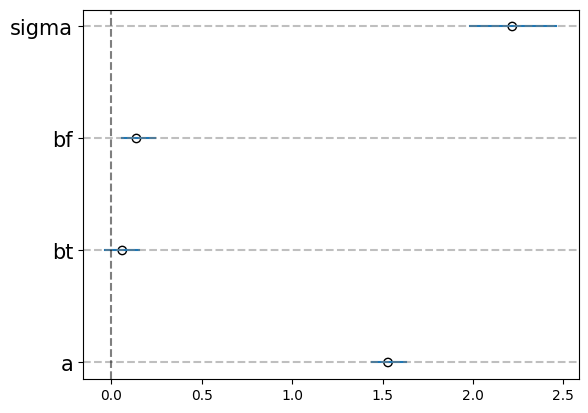

In [48]:
samples = sample_posterior(m6_7, 1000, ("a", "bt", "bf", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)

  0%|          | 0/1000 [00:00<?, ?it/s]

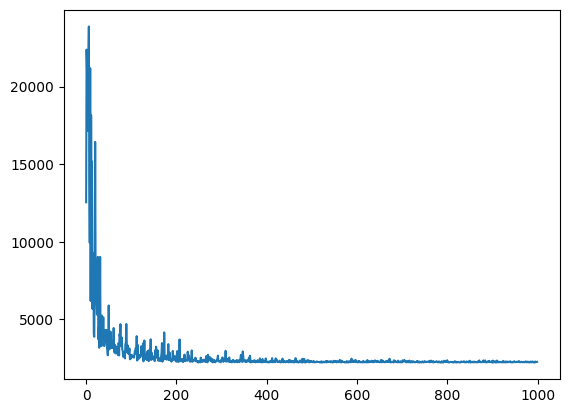

In [49]:
m6_8 = M6_8(d2, categoricals=["treatment", "fungus"])
loss = m6_8.train(1000)
plt.plot(loss); plt.show()

           mean    stddev     5.5%     94.5%
a      1.632252  0.049382  1.55295  1.712644
bt    -0.010223  0.058875 -0.10096  0.086427
sigma  2.257477  0.159592  2.00751  2.520638


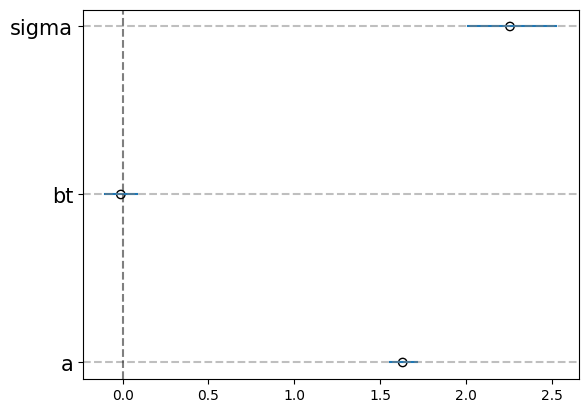

In [50]:
samples = sample_posterior(m6_8, 1000, ("a", "bt", "bf", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)